# Aprendizaje automático con extracción automática de características (node2vect)

In [1]:
import networkx as nx
from node2vec import Node2Vec
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score

/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Datos
edges = pd.read_csv("../data/raw/musae_git_edges.csv")
features = pd.read_csv("../data/raw/musae_git_features.csv")
target = pd.read_csv("../data/raw/musae_git_target.csv")

In [5]:
G = nx.from_pandas_edgelist(edges,'id_1','id_2')

In [7]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**

node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=1, workers=4, temp_folder="temp/", seed= 1, p=1, q=1)  # Use temp_folder for big graphs

Computing transition probabilities: 100%|██████████| 37700/37700 [06:04<00:00, 103.38it/s] 

Generating walks (CPU: 2): 0it [00:00, ?it/s]
Generating walks (CPU: 1):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 3): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|██████████| 1/1 [00:22<00:00, 22.60s/it]


In [8]:
# Embed nodes

model = node2vec.fit(window=10, # specifies the context window size for the Word2Vec model
                     min_count=1, # minimum frequency of nodes to be included in the model
                     batch_words=1000 #number of words (nodes) processed in each training batch by the Word2Vec
                     )

In [9]:
# Save model for later use

model.save("../models/node2vec_128_30_1_1_1")


In [ ]:
# from gensim.models import Word2Vec

# model = Word2Vec.load(EMBEDDING_MODEL_FILENAME)
# vector = model.wv['node1'] 

In [23]:
# Retrieve node embeddings and corresponding subjects

node_ids = model.wv.index_to_key
node_targets = target["ml_target"][[int(node_id) for node_id in node_ids]]

In [30]:
# Get the embedding

node_embeddings = model.wv.vectors # numpy.ndarray of size number of nodes times embeddings dimensionality
node_embeddings.shape # dims

(37700, 128)

In [31]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

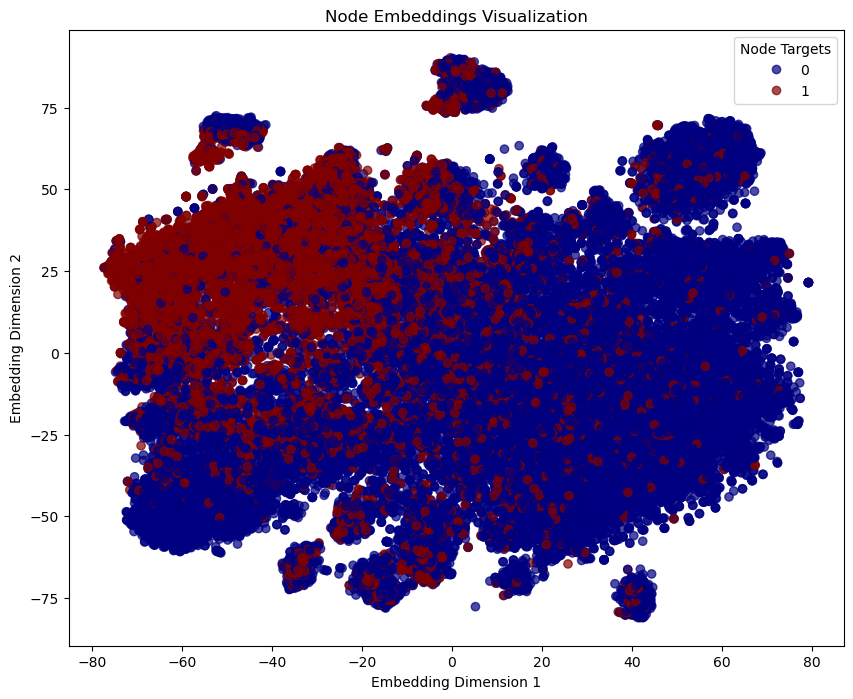

In [38]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

# Add a legend
legend_labels = [str(label) for label in np.unique(node_targets)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Targets", loc="best")


# Show the plot
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Node Embeddings Visualization")
plt.show()

In [39]:
# X will hold the 128-dimensional input features
X = node_embeddings

# y holds the corresponding target values
y = np.array(node_targets)

In [50]:
np.savetxt("../data/processed/X_node2vect.csv",X,delimiter=",")
np.savetxt("../data/processed/y_node2vect.csv",y,delimiter=",")

## Partición entrenamiento - test

Se realiza una partición aleatoria del conjunto de datos en entrenamiento y test.

In [5]:
X = np.loadtxt("../data/processed/X_node2vect.csv",delimiter=",")
y = np.loadtxt("../data/processed/y_node2vect.csv",delimiter=",")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=0)

## Modelos
Se han considerado los modelos de *Decision Tree*, *Random Forest*, Regresión logística *elastic net* y SVM.

La metodología seguida ha sido la misma en todos los casos:

1. Definir el modelo.
2. Definir el pipeline para el preprocesamiento y el modelado, con el objetivo de asegurar la consistecia durante el entrenamiento y la predicción. El pipeline está compuesto por:
    1. Scaler, aunque algunos modelos no necesiten el reescalado, este es imprescindible para los métodos de remuestreo considerados.
    2. Remuestreo. Al emplear métodos de remuestreo basados en distancia, estos son sensible a la heterocedasticidad de los datos. Es por ello que se remuestrea después de reescalar los datos.
    3. Modelo.
3. Ajustar los parámetros del modelo mediante validación cruzada. Entre los parámetros del modelo se ha considerado el tipo de remuestreo a emplear, ya que según el caso y el modelo un tipo de remuestreo puede ser preferible a otro.

Emplear validación cruzada en el ajuste de los modelos nos asegura que tomamos la mejor combinación de parámetros. Sin embargo, el costo computacional de esto es elevado.


### Decision Tree

In [6]:
dt = tree.DecisionTreeClassifier(random_state=0)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('resampler', None),         
    ('model', dt)  
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [None, ADASYN(random_state=0), NearMiss(version=1), SMOTETomek(random_state=0)],  # Resampling methods
    'model__max_depth': list(range(3,15)),  
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                              13, 14],
                         'resampler': [None, ADASYN(random_state=0), NearMiss(),
                                       SMOTETomek(random_state=0)]},
             scoring='balanced_accuracy', verbose=1)

In [1]:
# max_depth=3

0.7765250324060345


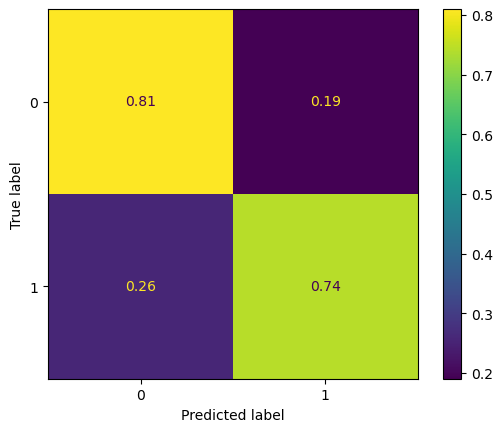

In [7]:
y_pred = grid.predict(X_test)


print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase


disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

In [ ]:
# dt = tree.DecisionTreeClassifier(max_depth=grid.best_params_["model__max_depth"])
# dt.fit(X_train,y_train)
# plt.figure(figsize=(12,12))
# tree.plot_tree(dt)

In [16]:
pd.DataFrame(grid.cv_results_["params"],grid.cv_results_["mean_test_score"])

,model__max_depth,resampler
0.727742,3,None
0.773795,3,ADASYN(random_state=0)
0.701042,3,NearMiss()
0.763011,3,SMOTETomek(random_state=0)
0.732006,4,None
0.748741,4,ADASYN(random_state=0)
0.710988,4,NearMiss()
0.771148,4,SMOTETomek(random_state=0)
0.742546,5,None
0.744689,5,ADASYN(random_state=0)


### Random forest

In [25]:
rf = RandomForestClassifier(random_state=0)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Step 1: Scaling
    ('resampler', None),          # Step 2: Placeholder for resampling
    ('model', rf)  # Step 3: Logistic Regression
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [SMOTETomek(random_state=0)],  # Resampling methods
    'model__max_depth': list(range(1,17,5)),
    'model__n_estimators':  [100,200,300]
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [1, 6, 11, 16],
                         'model__n_estimators': [100, 200, 300],
                         'resampler': [SMOTETomek(random_state=0)]},
             scoring='balanced_accuracy', verbose=1)

In [26]:
# max_depth=11, n_stimators=300

0.7944423248928973


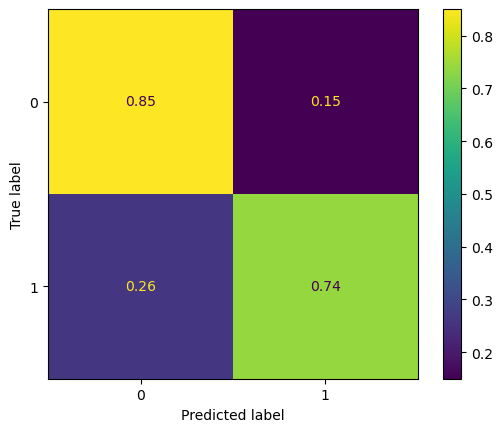

In [27]:
y_pred = grid.predict(X_test)


print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase


disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

### Logistic regresion

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="elasticnet", solver="saga",random_state=0) # saga is an stochastic optimizer

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Step 1: Scaling
    ('resampler', None),          # Step 2: Placeholder for resampling
    ('model', lr)  # Step 3: Logistic Regression
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [None, ADASYN(random_state=0), NearMiss(version=1), SMOTETomek(random_state=0)],  # Resampling methods
    'model__C':  [0.1,0.5,1,5,10], # Inverse of regularization stregth, smaller values more regu
    'model__l1_ratio':  [0,0.5,1]
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juan/miniconda3/envs/rapids-24.12/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model',
                                        LogisticRegression(penalty='elasticnet',
                                                           random_state=0,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.5, 1, 5, 10],
                         'model__l1_ratio': [0, 0.5, 1],
                         'resampler': [None, ADASYN(random_state=0), NearMiss(),
                                       SMOTETomek(random_state=0)]},
             scoring='balanced_accuracy', verbose=1)

In [2]:
# C=0.1, l1_ratio=1, resampler = SMOTETomek

0.7898738876874749


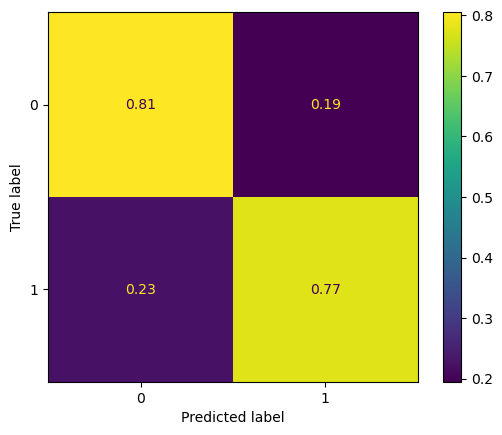

In [20]:
y_pred = grid.predict(X_test)

print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase

disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()

### SVM

In [22]:
svc = SVC(random_state=0)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Step 1: Scaling
    ('resampler', None),          # Step 2: Placeholder for resampling
    ('model', svc)  # Step 3: Logistic Regression
])

# Define parameter grid with different resamplers
param_grid = {
    'resampler': [SMOTETomek(random_state=0)],  # Resampling methods
    'model__kernel': ["rbf"],
    'model__C':  [0.5,1,5], # Regularization parameter. The strength of the regularization is inversely proportional to C.
    'model__gamma': ["scale", "auto"]
}

# Create GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('resampler', None),
                                       ('model', SVC(random_state=0))]),
             n_jobs=8,
             param_grid={'model__C': [0.5, 1, 5],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['rbf'],
                         'resampler': [SMOTETomek(random_state=0)]},
             scoring='balanced_accuracy', verbose=1)

In [23]:
# {'model__C': 0.5, 'model__kernel': 'rbf', gamma = 'auto','resampler': SMOTETomek()}

0.7938582930116276


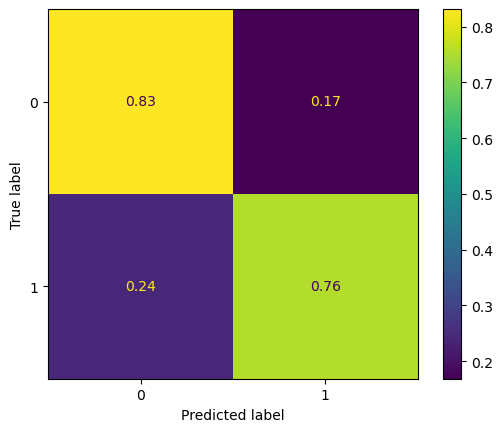

In [24]:
y_pred = grid.predict(X_test)


print(balanced_accuracy_score(y_true=y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred, normalize="true") # Se muestra el recall en cada clase


disp = ConfusionMatrixDisplay(confu_mat)
disp.plot()